In [1]:
import pandas as pd
import pybaseball

# Optional: from pybaseball import standings

In [2]:
reg_wins = pd.concat(pybaseball.standings(), ignore_index = True)

In [5]:
vegas = pd.concat(pd.read_html('https://www.covers.com/mlb/win-totals-odds'), ignore_index = True, axis = 0)

In [33]:
vegas[vegas['Team'] == 'Oakland A\'s']

,Team,Total,Over,Under
25,Oakland A's,57.5,-105,-115


In [7]:
reg_vegas = pd.merge(reg_wins, vegas, left_on = 'Tm', right_on = 'Team', how = 'left').fillna(57.5)[['Tm', 'W', 'Total']]

In [8]:
reg_vegas.dtypes

Tm        object
W         object
Total    float64
dtype: object

In [9]:
reg_vegas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tm      30 non-null     object 
 1   W       30 non-null     object 
 2   Total   30 non-null     float64
dtypes: float64(1), object(2)
memory usage: 852.0+ bytes


In [10]:
reg_vegas

,Tm,W,Total
0,New York Yankees,94,91.5
1,Baltimore Orioles,91,90.5
2,Boston Red Sox,81,77.5
3,Tampa Bay Rays,80,84.5
4,Toronto Blue Jays,74,86.5
5,Cleveland Guardians,92,79.5
6,Kansas City Royals,86,74.5
7,Detroit Tigers,86,80.5
8,Minnesota Twins,82,86.5
9,Chicago White Sox,41,61.5


In [16]:
import requests
from bs4 import BeautifulSoup

base_url = 'https://teamcolorcodes.com/{}-color-codes/'

hex_dict = {}

for team in reg_vegas['Tm']:
    fmt_name = team.replace(' ', '-').lower()
    
    url = base_url.format(fmt_name)
    
    response = requests.get(url)
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    try:
        hex_dict[team] = soup.find('div', class_='colorblock')['style'].split(' ')[1].split(';')[0]
    
    except TypeError:
        hex_dict[team] = None

{'New York Yankees': '#003087', 'Baltimore Orioles': '#df4601', 'Boston Red Sox': '#bd3039', 'Tampa Bay Rays': '#092c5c', 'Toronto Blue Jays': '#134a8e', 'Cleveland Guardians': None}


In [20]:
hex_dict['Cleveland Guardians'] = '#00385D'

In [43]:
int('2')

2

In [22]:
reg_vegas['residuals'] = reg_vegas['W'].astype(float) - reg_vegas['Total']

In [23]:
reg_vegas.sort_values(by='residuals', inplace = True)

In [25]:
reg_vegas['color'] = reg_vegas['Tm'].map(hex_dict)

In [32]:
def make_keys(words: list[str]) -> dict:
    """
    Makes the team abbreviations for MLB.com teams such as CLE. 
    """
    keys = []
    for text in words:
        text = text.split()
        abbr = [word[0] for word in text if word[0].isupper()]
        if len(text) == 2:
            abbr = text[0][:3].upper()
        abbr = ''.join(abbr)
        keys.append(abbr)
    
    # Manually fix these for fangraphs merge
    wrong_ones = {
        'STL' : 'SLC',
        'TOR' : 'TBJ',
        'BOS' : 'BRS',
        'CHW' : 'CWS',
        'CHC' : 'CHI',
        'WSN' : 'WAS'
    }
    
    new_list = []
    for k in keys:
        new_k = [abbr for abbr, val in wrong_ones.items() if k == val]
        k = new_k[0] if new_k else k
        new_list.append(k)

    return new_list

In [38]:
reg_vegas['abbr'] = make_keys(reg_vegas['Tm'])

In [41]:
reg_vegas.sort_values(by='abbr', inplace = True)

In [47]:
reg_vegas['id'] = range(1, len(reg_vegas) + 1)

In [50]:
reg_vegas.head()

,Tm,W,Total,residuals,color,abbr,id
27,Arizona Diamondbacks,89,84.5,4.5,#a71930,ARI,1
16,Atlanta Braves,89,101.5,-12.5,#ce1141,ATL,2
1,Baltimore Orioles,91,90.5,0.5,#df4601,BAL,3
2,Boston Red Sox,81,77.5,3.5,#bd3039,BOS,4
21,Chicago Cubs,83,84.5,-1.5,#0e3386,CHC,5


In [57]:
import os

logo_path = '/Users/eddie/Eddie_Dew_Python/mlb_logos'

logos = os.listdir(logo_path)

l_dict = {}

for logo in logos:
    try:
        id_ = int(logo.split('.')[0])
        l_dict[id_] = os.path.join(logo_path, logo)
    except ValueError:
        continue


In [59]:
reg_vegas['logo_path'] = reg_vegas['id'].map(l_dict)

In [62]:
reg_vegas.sort_values(by='residuals', inplace = True)

In [78]:
reg_vegas.reset_index(drop = True, inplace = True)


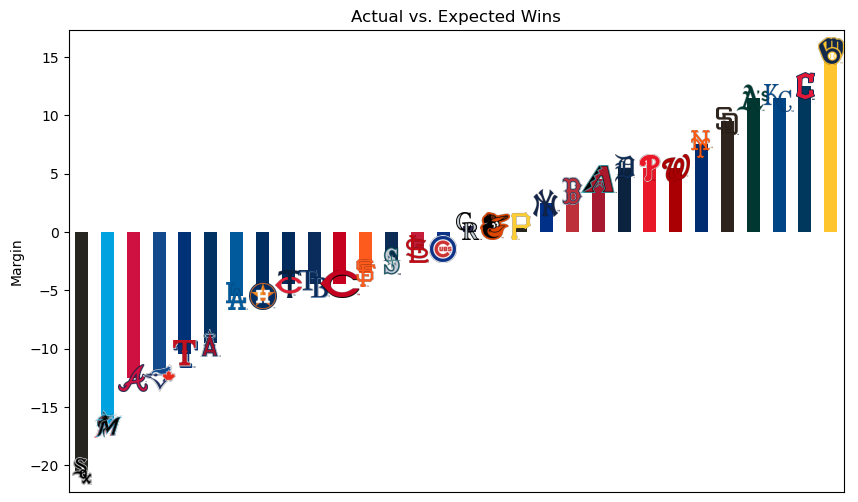

In [80]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots()

def add_logo(ax, path, xy):
    image = plt.imread(path)
    imagebox = OffsetImage(image, zoom = (20 / image.shape[0]), resample = True)
    ab = AnnotationBbox(imagebox, xy=xy, frameon = False)
    ax.add_artist(ab)
    

reg_vegas.plot(y='residuals', kind='bar', legend = False, xticks=[], title='Actual vs. Expected Wins', figsize=(10, 6), ylabel = 'Margin', color = reg_vegas['color'], ax = ax)

for i, team in reg_vegas.iterrows():
    add_logo(ax=ax, path = team['logo_path'], xy=(i, team['residuals']))



